In [1]:
import warnings
import itertools
import numpy as np
import verde as vd
import pandas as pd
import xarray as xr
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import eqs_magnetics as eqs

In [2]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)

Set the data coordinates and field direction.

N data: 92046


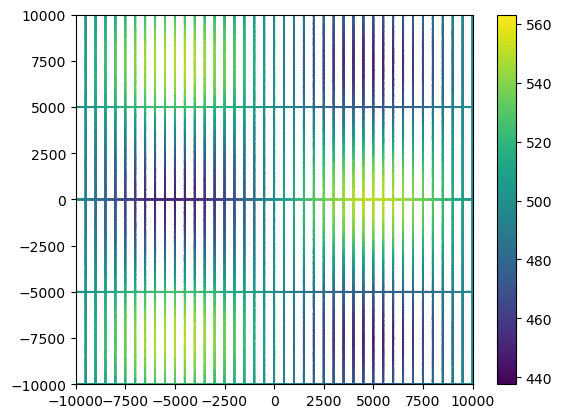

In [3]:
region = [-10e3, 10e3, -10e3, 10e3]
# Inc and dec from the IGRF around Antarctica
field_direction = eqs.angles_to_vector(inclination=-75, declination=-70, amplitude=1)
#field_direction = eqs.angles_to_vector(inclination=84, declination=120, amplitude=1)

# Generate fake flight lines
easting, northing = [c.ravel() for c in vd.grid_coordinates(region, spacing=(10, 500))]
easting_tie, northing_tie = [c.ravel() for c in vd.grid_coordinates(region, spacing=(5000, 10))]
easting = np.concatenate([easting, easting_tie])
northing = np.concatenate([northing, northing_tie])
upward = vd.synthetic.CheckerBoard(region=region, amplitude=50, w_east=20000, w_north=15000).predict((easting, northing)) + 500
coordinates = (easting, northing, upward)
for i, c in enumerate(coordinates):
    eqs.contaminate(c, standard_deviation=4, random_state=i)

print("N data:", coordinates[0].size)

plt.scatter(*coordinates[:2], c=coordinates[2], s=0.1)
plt.xlim(*region[:2])
plt.ylim(*region[2:])
plt.colorbar()
plt.show()

In [4]:
dipole_moments = []
source_coordinates = []
# Regional
source_coordinates.append([[-1500], [-2000], [-6e3]])
dipole_moments.append(eqs.angles_to_vector(-65, -80, 5e11))

source_coordinates.append([[0], [0], [-5e3]])
dipole_moments.append(eqs.angles_to_vector(-65, -80, 5e11))

source_coordinates.append([[1500], [2000], [-5e3]])
dipole_moments.append(eqs.angles_to_vector(-65, -80, 5e11))


# Point source top left
source_coordinates.append([[-6000], [6000], [-90]])
dipole_moments.append(eqs.angles_to_vector(-50, 40, 15e8))

# Point source middle
source_coordinates.append([[500], [300], [-300]])
dipole_moments.append(eqs.angles_to_vector(55, 30, 50e8))

# point source bottom right
source_coordinates.append([[7000], [-7000], [-150]])
dipole_moments.append(eqs.angles_to_vector(40, 55, 15e8))

source_coordinates = np.concatenate(source_coordinates, axis=1)
dipole_moments = np.concatenate(dipole_moments, axis=1)

In [5]:
b_field = eqs.dipole_magnetic(coordinates, source_coordinates, dipole_moments)
tfa = eqs.contaminate(
    eqs.total_field_anomaly(b_field, field_direction), standard_deviation=50, random_state=42,
)
bnorm = eqs.magnetic_field_norm(b_field)

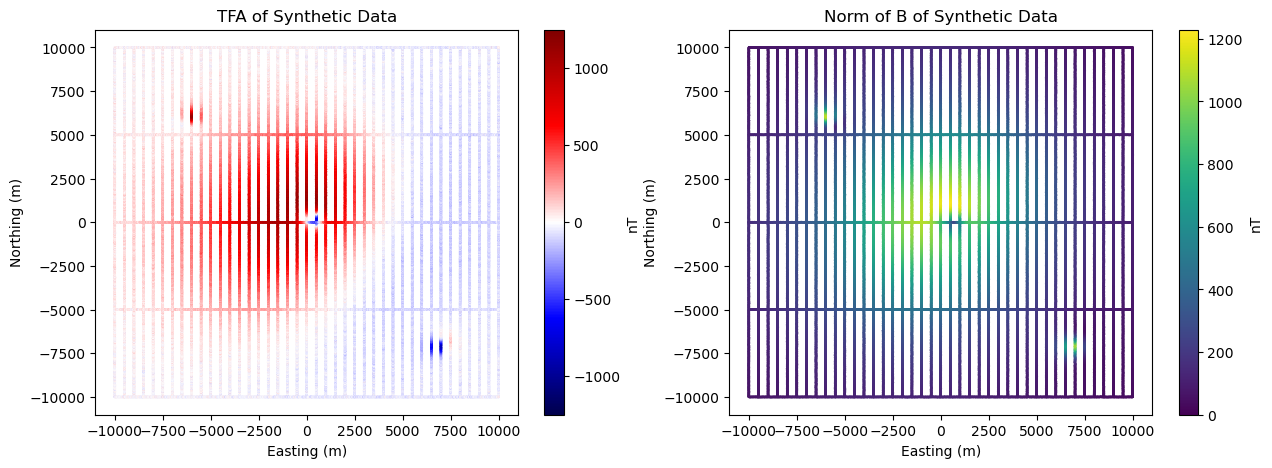

In [6]:
plt.figure(figsize=(15,5))
scale = vd.maxabs(tfa)
#scale = 1000
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa, cmap="seismic", s=0.5, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

scale_bnorm = vd.maxabs(bnorm)
plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=bnorm, cmap="viridis", s=0.5, vmin=0, vmax=scale_bnorm)
plt.title("Norm of B of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit deep sources¶

In [7]:
reducer = vd.BlockReduce(reduction=np.median, spacing=2e3, drop_coords=False)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=tfa)

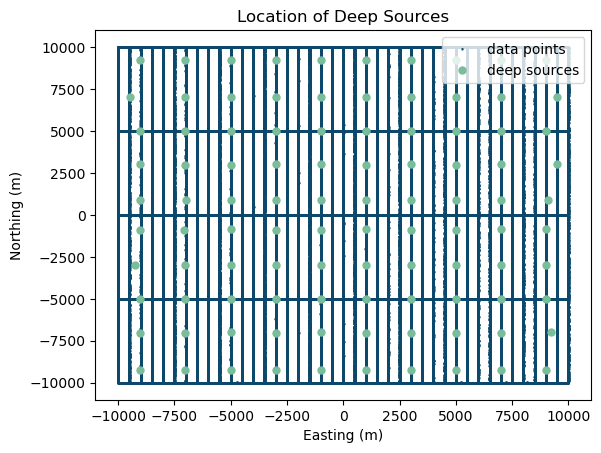

In [8]:
plt.figure()
plt.plot(*coordinates[:2], "v", color="#0B486B", markersize=1, label='data points')
plt.plot(*coords_blocked[:2], "o", color="#79BD9A", markersize=5, label='deep sources')
plt.title("Location of Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend()
plt.show()

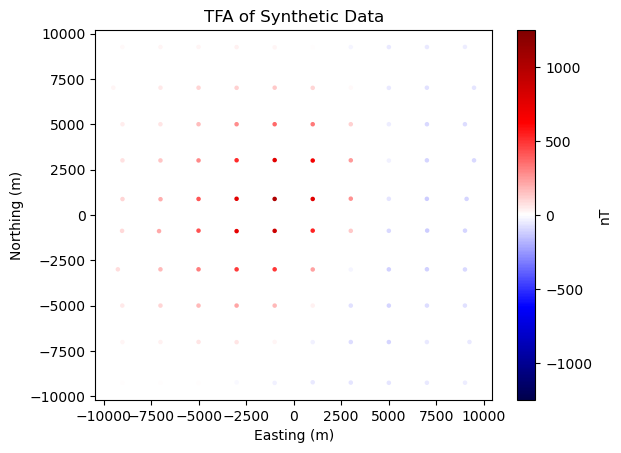

In [9]:
plt.figure()
plt.scatter(*coords_blocked[:2], c=tfa_blocked, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

In [10]:
dampings = [1e-4, 1e-3, 1e-2]
spacing = np.mean(vd.median_distance(coords_blocked))
depths = [spacing*2.5, spacing*4.25, spacing*6]
parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))
# print("Combinations:", parameter_sets)

Number of combinations: 9


In [11]:
%%time
kfold = vd.BlockKFold(
    spacing=2500,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coords_blocked[:2])
scores = []
for parameters in parameter_sets:    
    print(parameters)
    eqs_deep = eqs.EquivalentSourcesMagnetic(block_size=100, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_deep.fit(
            [c[train] for c in coords_blocked], 
            tfa_blocked[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_deep.predict([c[test] for c in coords_blocked]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_blocked[test] - predicted))
    scores.append(np.mean(tmp))
    print(np.mean(tmp))

{'damping': 0.0001, 'depth': 4882.187872678555}
153.65014773306467
{'damping': 0.0001, 'depth': 8299.719383553544}
61.7126516667813
{'damping': 0.0001, 'depth': 11717.250894428533}
64.96117746022463
{'damping': 0.001, 'depth': 4882.187872678555}
153.69385436837646
{'damping': 0.001, 'depth': 8299.719383553544}
58.64640963317483
{'damping': 0.001, 'depth': 11717.250894428533}
86.21186324677315
{'damping': 0.01, 'depth': 4882.187872678555}
154.1111821406418
{'damping': 0.01, 'depth': 8299.719383553544}
66.73391995711592
{'damping': 0.01, 'depth': 11717.250894428533}
117.3173581432811
CPU times: user 1min 58s, sys: 47.9 s, total: 2min 45s
Wall time: 5.12 s


In [12]:
best = np.argmin(scores)
parameter_sets[best]

{'damping': 0.001, 'depth': 8299.719383553544}

In [13]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(**parameter_sets[best])
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

source height: -7791.358417006153
CPU times: user 1.1 s, sys: 269 ms, total: 1.37 s
Wall time: 274 ms


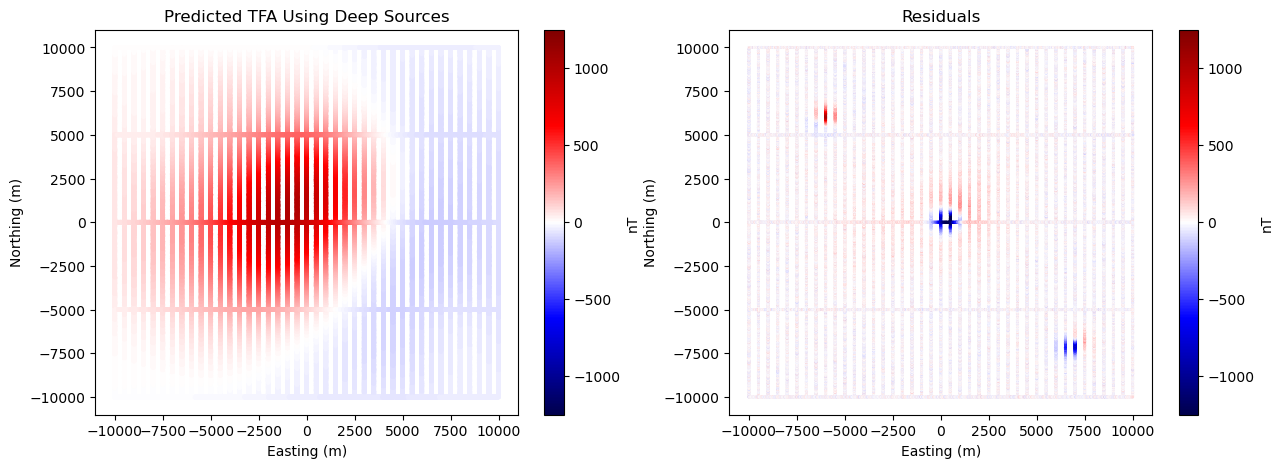

In [14]:
tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = tfa - tfa_deep

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_deep, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=tfa_residuals, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit the deep residuals with gradient-boosted sources

In [15]:
dampings = [1e1, 1e2, 1e3]
depths = [500, 1e3, 1.5e3]
# spacing = np.mean(vd.median_distance(coordinates))
# depths = [spacing*2.5, spacing*4.25, spacing*6]
parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))
# print("Combinations:", parameter_sets)

Number of combinations: 9


In [16]:
%%time
kfold = vd.BlockKFold(
    spacing=500,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores = []
for parameters in parameter_sets:    
    print(parameters)
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=100, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_residuals[test] - predicted))
    scores.append(np.mean(tmp))
    print(np.mean(tmp))

{'damping': 10.0, 'depth': 500}
7692.857570358892
{'damping': 10.0, 'depth': 1000.0}
7229.3840988872125
{'damping': 10.0, 'depth': 1500.0}
7239.663380411568
{'damping': 100.0, 'depth': 500}
7483.868477840013
{'damping': 100.0, 'depth': 1000.0}
7121.817562152927
{'damping': 100.0, 'depth': 1500.0}
7342.705885489701
{'damping': 1000.0, 'depth': 500}
7403.165241136821
{'damping': 1000.0, 'depth': 1000.0}
7150.375278589925
{'damping': 1000.0, 'depth': 1500.0}
7567.543541326083
CPU times: user 2h 12min, sys: 36min 15s, total: 2h 48min 16s
Wall time: 7min 16s


In [17]:
best = np.argmin(scores)
parameter_sets[best]

{'damping': 100.0, 'depth': 1000.0}

In [18]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=100, **parameter_sets[best])
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)
print("dipole height:", eqs_shallow.dipole_coordinates_[2][0])
print("window size:", eqs_shallow.window_size_)

dipole height: -501.0235550450832
window size: 4667.985732163489
CPU times: user 3min 54s, sys: 1min 3s, total: 4min 57s
Wall time: 11.8 s


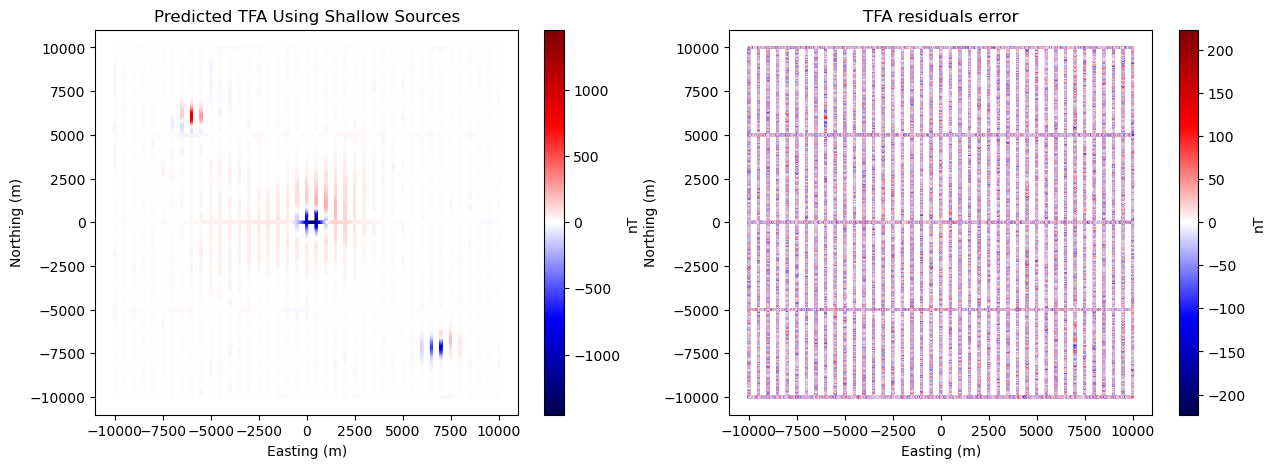

In [19]:
tfa_residuals_prediction = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure(figsize=(15,5))
scale = vd.maxabs(tfa_residuals_prediction)
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_residuals_prediction, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Shallow Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
scale = vd.maxabs(tfa_residuals - tfa_residuals_prediction)
plt.scatter(*coordinates[:2], c=tfa_residuals - tfa_residuals_prediction, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("TFA residuals error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Predict the norm of B

In [20]:
grid_coordinates = vd.grid_coordinates(region, spacing=100, extra_coords=500)
true_b = eqs.dipole_magnetic(grid_coordinates, source_coordinates, dipole_moments)
predicted_b = eqs_deep.predict(grid_coordinates) + eqs_shallow.predict(grid_coordinates)

true_tfa = eqs.total_field_anomaly(true_b, field_direction)
predicted_tfa = eqs.total_field_anomaly(predicted_b, field_direction)
error_tfa = true_tfa - predicted_tfa

In [21]:
true_norm_of_b = np.sqrt(sum(c**2 for c in true_b))
predicted_norm_of_b = np.sqrt(sum(c**2 for c in predicted_b))
error_norm_of_b = true_norm_of_b - predicted_norm_of_b

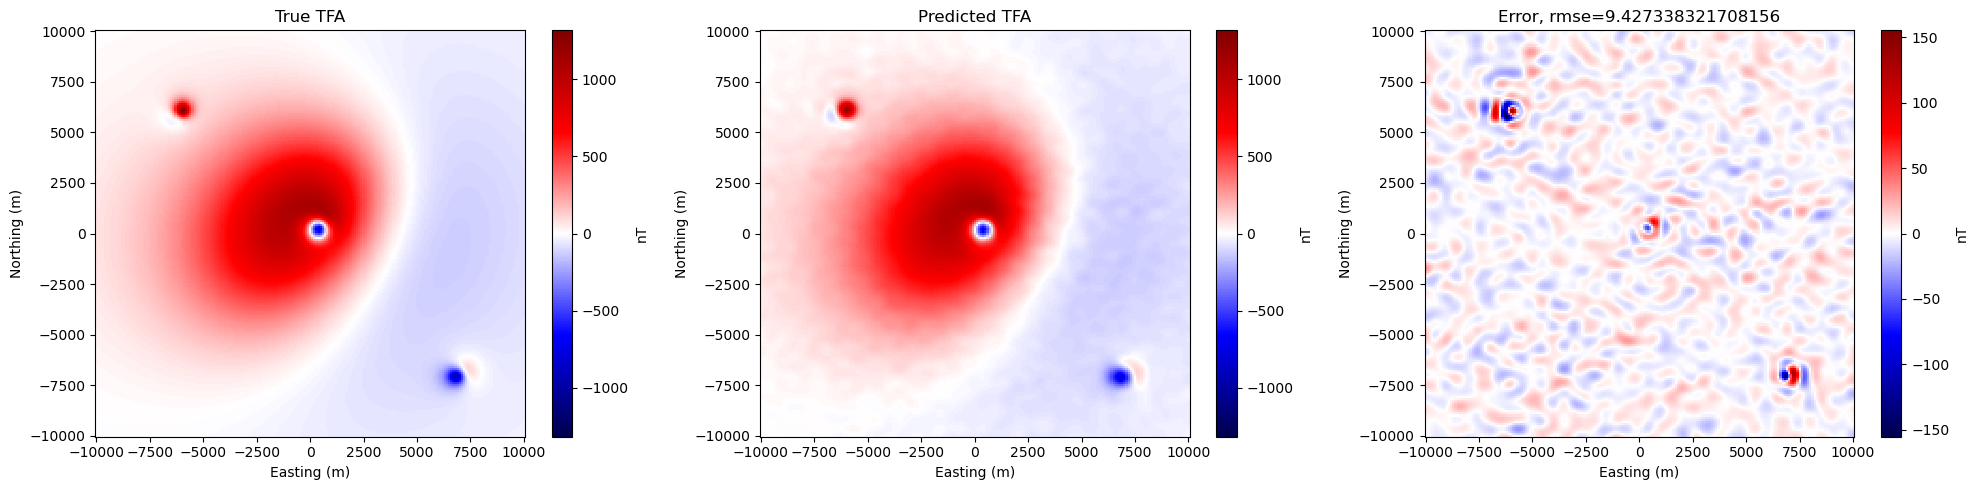

In [22]:
scale_tfa = vd.maxabs(true_tfa)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="seismic", vmin=-scale_tfa, vmax=scale_tfa)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(*grid_coordinates[:2], predicted_tfa, cmap="seismic", vmin=-scale_tfa, vmax=scale_tfa)
plt.title("Predicted TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
diff_scale = vd.maxabs(error_tfa)
rmse_tfa = np.sqrt(np.square(error_tfa).mean())
plt.pcolormesh(*grid_coordinates[:2], error_tfa, cmap="seismic", vmin=-diff_scale, vmax=diff_scale)
plt.title('Error, rmse={}'.format(rmse_tfa))
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

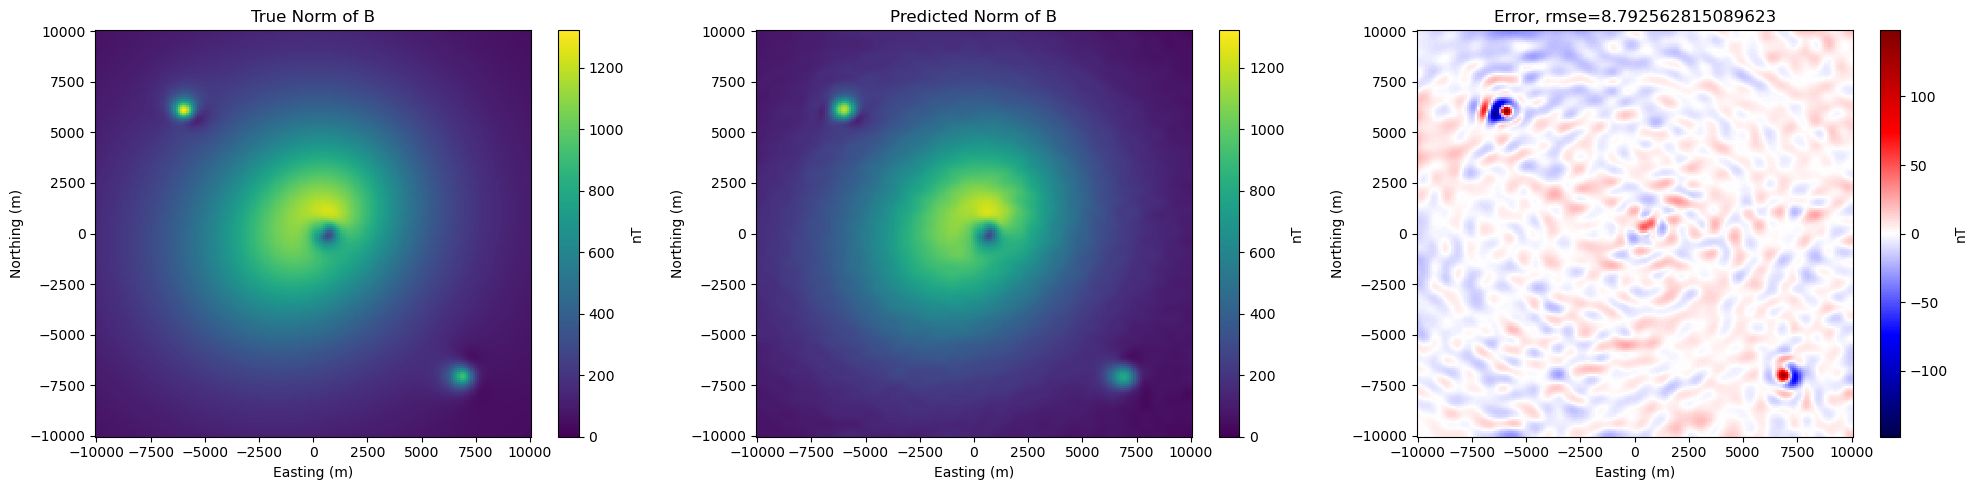

In [23]:
scale_b = vd.maxabs(true_norm_of_b)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(*grid_coordinates[:2], true_norm_of_b, cmap="viridis", vmin=0, vmax=scale_b)
plt.title("True Norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(*grid_coordinates[:2], predicted_norm_of_b, cmap="viridis", vmin=0, vmax=scale_b)
plt.title("Predicted Norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
diff_scale = vd.maxabs(error_norm_of_b)
rmse_bnorm = np.sqrt(np.square(error_norm_of_b).mean())
plt.pcolormesh(*grid_coordinates[:2], error_norm_of_b, cmap="seismic", vmin=-diff_scale, vmax=diff_scale)
plt.title('Error, rmse={}'.format(rmse_bnorm))
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()